<a href="https://colab.research.google.com/github/Alisser2001/QuantumMachineLearning/blob/emmadev/LOFBaseballQML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd

# URL del archivo raw en GitHub
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/baseball.dat"

# Descargar el contenido del archivo
response = requests.get(url)
lines = [line.strip() for line in response.text.splitlines()]

# Extraer atributos
attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]

# Extraer datos (después de @data)
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]

# Crear DataFrame
df = pd.DataFrame(data, columns=attributes).astype(float)

print(df.head())


In [ ]:
# =========================
# SETUP: paleta 'pastel' (nativa de seaborn)
# =========================
import math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

palette_name = "pastel"
sns.set_theme(style="whitegrid", context="notebook", palette=palette_name, font_scale=1.05)
pal = sns.color_palette(palette_name)

# colores explícitos extraídos de la paleta
color_main  = pal[2]    # para histogramas / puntos
color_kde   = pal[1]    # para KDE / líneas suaves
color_accent= pal[-1]   # para líneas de regresión o destaque
box_color   = pal[0]    # para boxplots inset

print("Paleta aplicada:", palette_name, " — Colores:", pal)


In [ ]:
# Vista rápida de los datos
print("Dimensiones:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nDescripción estadística:")
display(df.describe().T)

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nTipo de datos por columna:")
print(df.dtypes)

confirmamos que no hay valores nulos y que todos son números, por lo tanto no es necesario pensar en una transformación ni en una imputación de datos

In [ ]:
cols = df.columns.tolist()
n = len(cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4*rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(df[col], kde=False, bins=30, ax=ax, stat="density",
                 color=color_main, edgecolor="black", linewidth=0.35, alpha=0.9)
    sns.kdeplot(df[col], ax=ax, color=color_kde, linewidth=1.15)
    ax.set_title(f"{col} — Distribución", fontsize=11)
    ax.set_ylabel("Densidad")

    axins = inset_axes(ax, width="38%", height="18%", loc='upper right', borderpad=0.9)
    sns.boxplot(x=df[col], ax=axins, orient="h", width=0.55, color=box_color)
    axins.set_yticks([])
    axins.tick_params(axis='both', which='both', labelsize=8)
    for spine in axins.spines.values():
        spine.set_visible(False)

for j in range(n, rows*cols_per_row):
    fig.delaxes(axes[j])


fig.suptitle("Distribuciones univariadas (hist + KDE) — 3 por fila", fontsize=16)

plt.show()


In [ ]:
target = "Salary"
features = [c for c in df.columns if c != target]
n = len(features)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4*rows), constrained_layout=True)
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    sns.scatterplot(x=df[feat], y=df[target], ax=ax,
                    color=color_main, edgecolor="w", linewidth=0.25, s=28, alpha=0.75)
    sns.regplot(x=df[feat], y=df[target], scatter=False, ax=ax, truncate=True,
                line_kws={"linewidth":1.6, "color": color_accent})
    ax.set_title(f"{feat} vs {target}", fontsize=11)
    ax.set_xlabel(feat)
    ax.set_ylabel(target)
    ax.grid(alpha=0.2)

for j in range(n, rows*cols_per_row):
    fig.delaxes(axes[j])

fig.suptitle(f"Relación: features vs {target} — scatter + tendencia (3 por fila)", fontsize=16)
plt.show()


In [ ]:
corr = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=0.5, cbar_kws={"shrink":0.8})
plt.title("Matriz de correlación (Pearson)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nCorrelación con la variable objetivo (orden descendente):")
display(corr[target].sort_values(ascending=False))





---



In [ ]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

In [ ]:

# Parámetros
features = df.columns.tolist()  # lista explícita

X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) Ajustar LOF
lof = LocalOutlierFactor(novelty=False)
y_pred = lof.fit_predict(X_scaled)  # 1 -> inlier, -1 -> outlier
neg_lof_scores = lof.negative_outlier_factor_  # valores negativos: más negativo = más atípico
# convertimos a score positivo (cuanto mayor, más atípico)
lof_score = -neg_lof_scores

In [ ]:
# Añadir columnas al DataFrame original (no escala)
df = df.copy()  # evitar modificar df original fuera del scope
df["lof_score"] = lof_score
df["is_outlier"] = y_pred == -1

# 4) Resumen rápido
n_outliers = df["is_outlier"].sum()
print(f"Total de muestras: {len(df)}")
print(f"Outliers detectados (is_outlier=True): {n_outliers}  —  Contamination usado: {20}")

# Mostrar top N más atípicos (por lof_score)
top_n = 10
print(f"\nTop {top_n} muestras más atípicas (por lof_score):")
display(df.sort_values("lof_score", ascending=False).head(top_n))

# 5) Visualizaciones: univariadas y bivariadas con outliers destacados
cols = features
n = len(cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

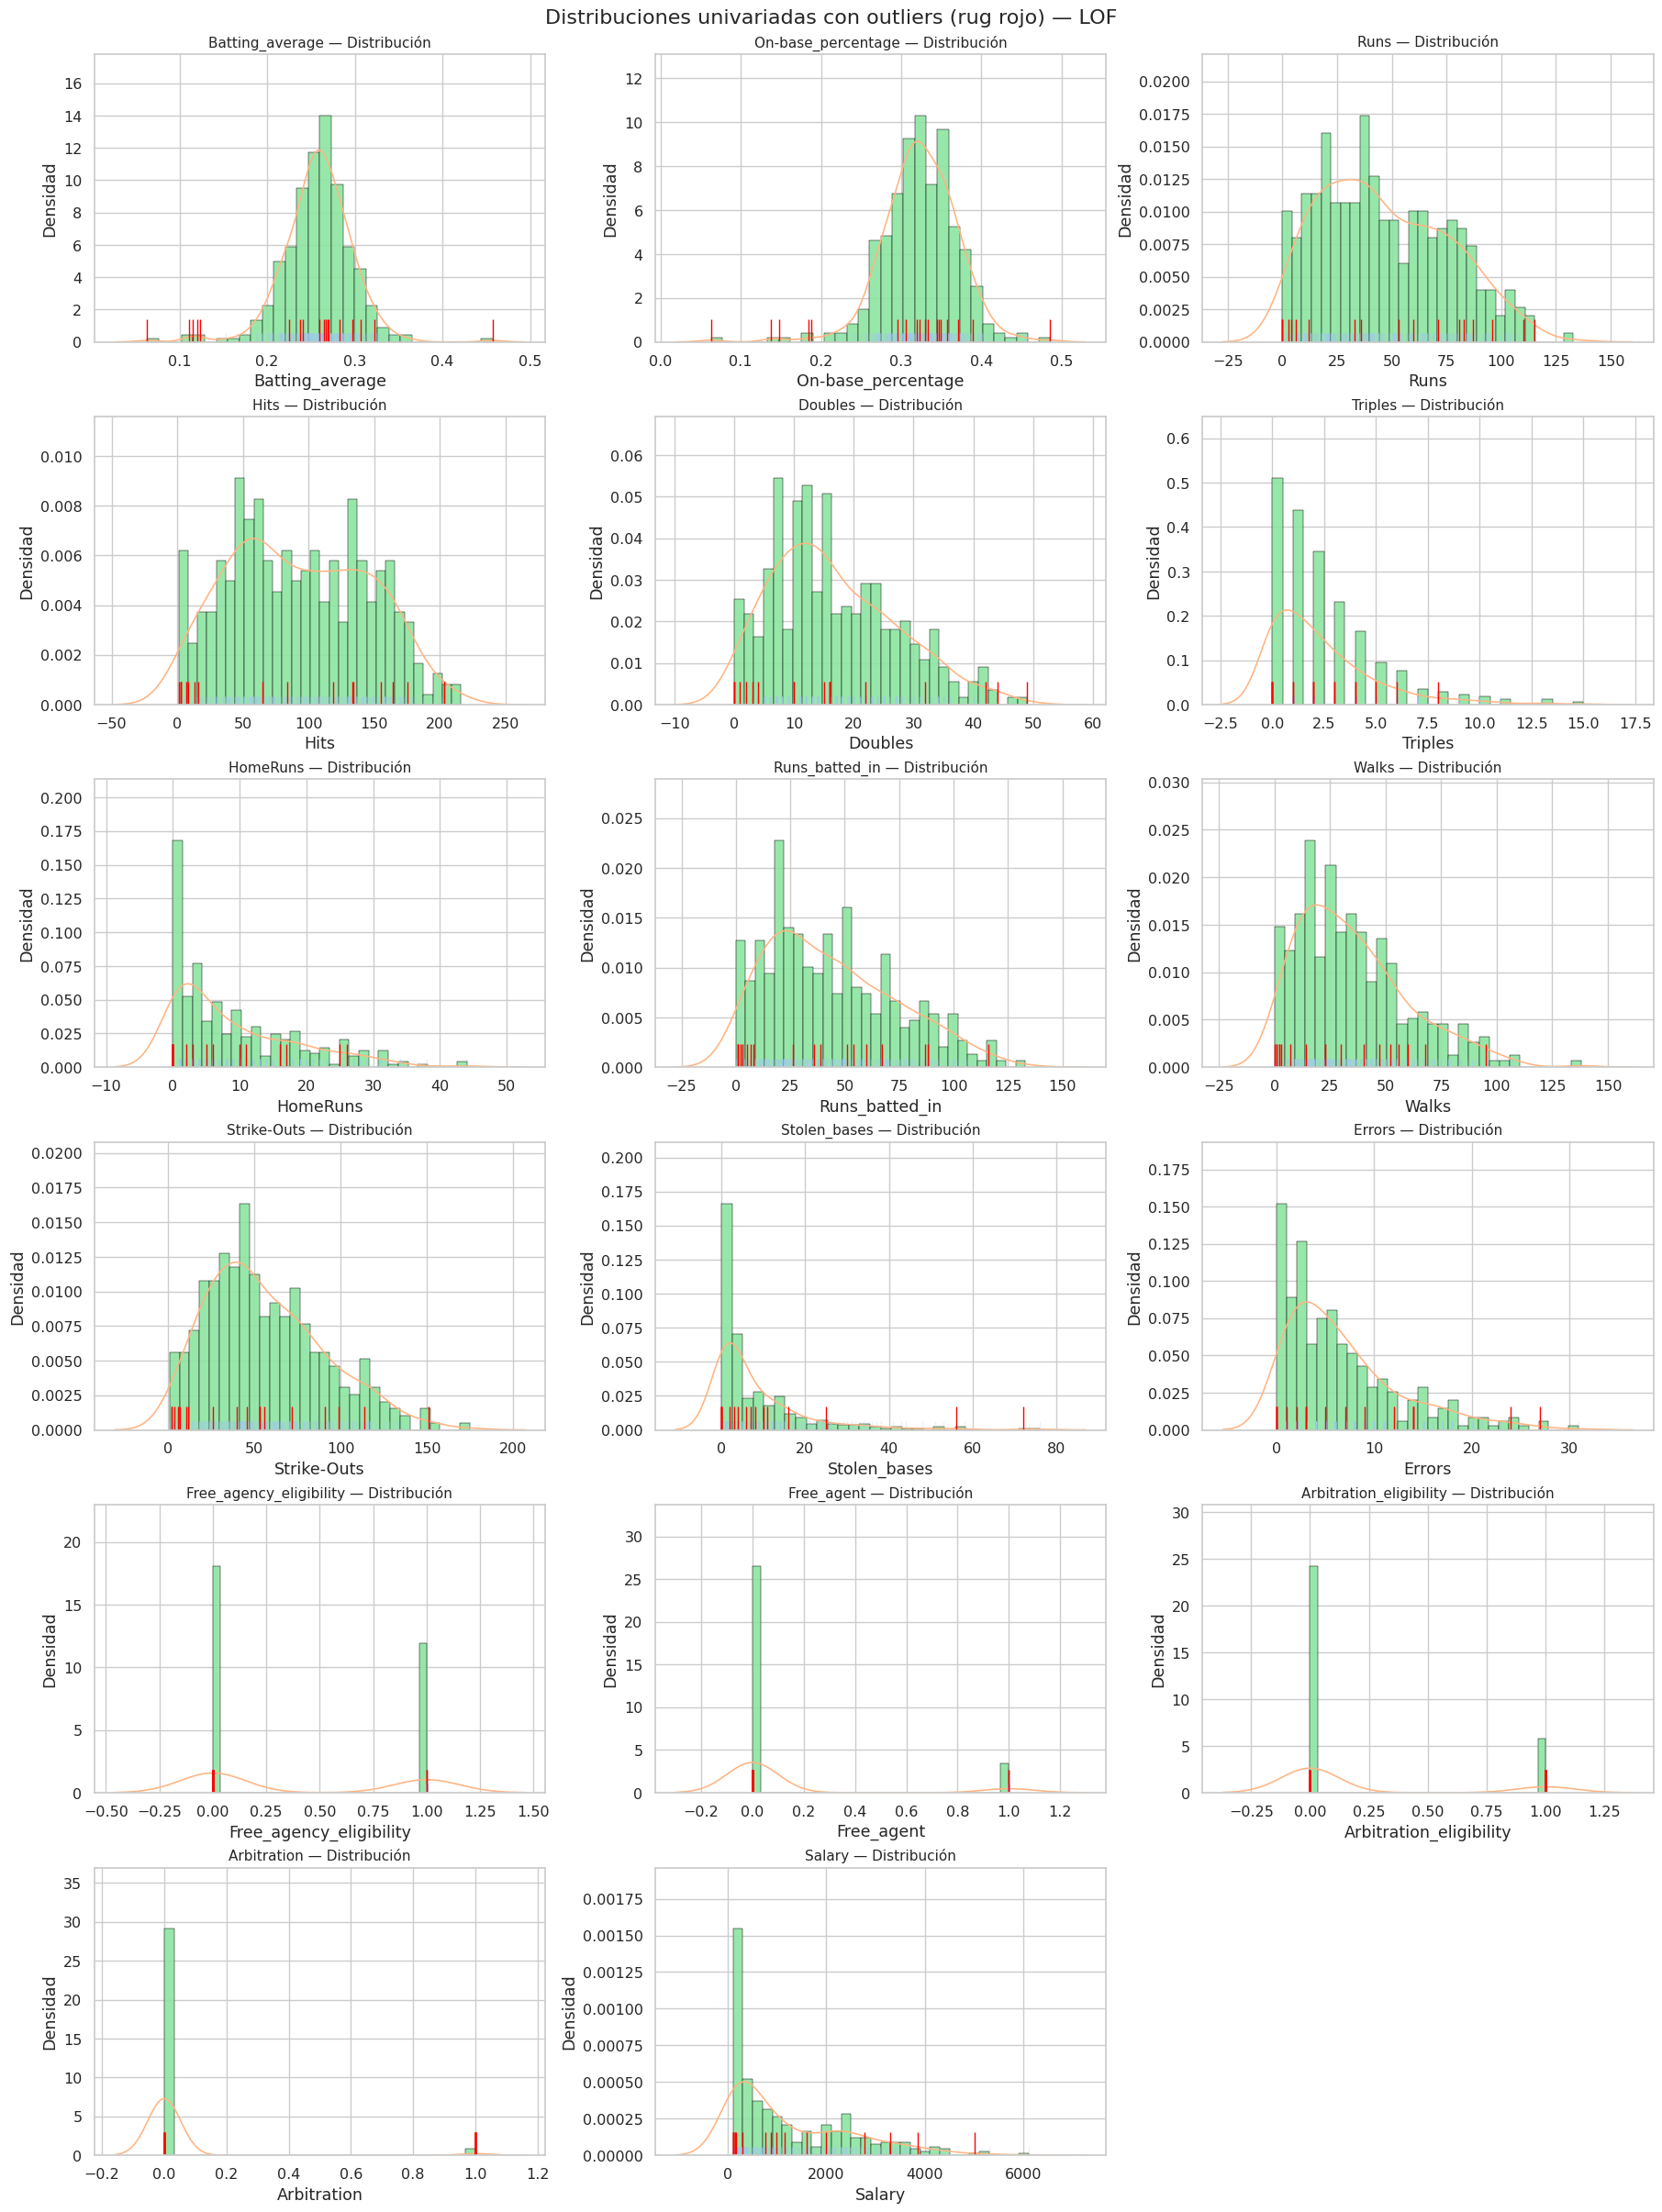

In [10]:

# Distribuciones univariadas: hist + KDE + rug con outliers en rojo
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4*rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(df[col], kde=False, bins=30, ax=ax, stat="density",
                 color=color_main, edgecolor="black", linewidth=0.35, alpha=0.9)
    sns.kdeplot(df[col], ax=ax, color=color_kde, linewidth=1.15, fill=False)
    ax.set_title(f"{col} — Distribución", fontsize=11)
    ax.set_ylabel("Densidad")
    # rug para inliers (sutil)
    sns.rugplot(df.loc[~df["is_outlier"], col], ax=ax, height=0.03, alpha=0.25)
    # rug para outliers (destacado en rojo)
    sns.rugplot(df.loc[df["is_outlier"], col], ax=ax, height=0.08, color="red")


for j in range(n, rows*cols_per_row):
    fig.delaxes(axes[j])

fig.suptitle("Distribuciones univariadas con outliers (rug rojo) — LOF", fontsize=16)
plt.show()

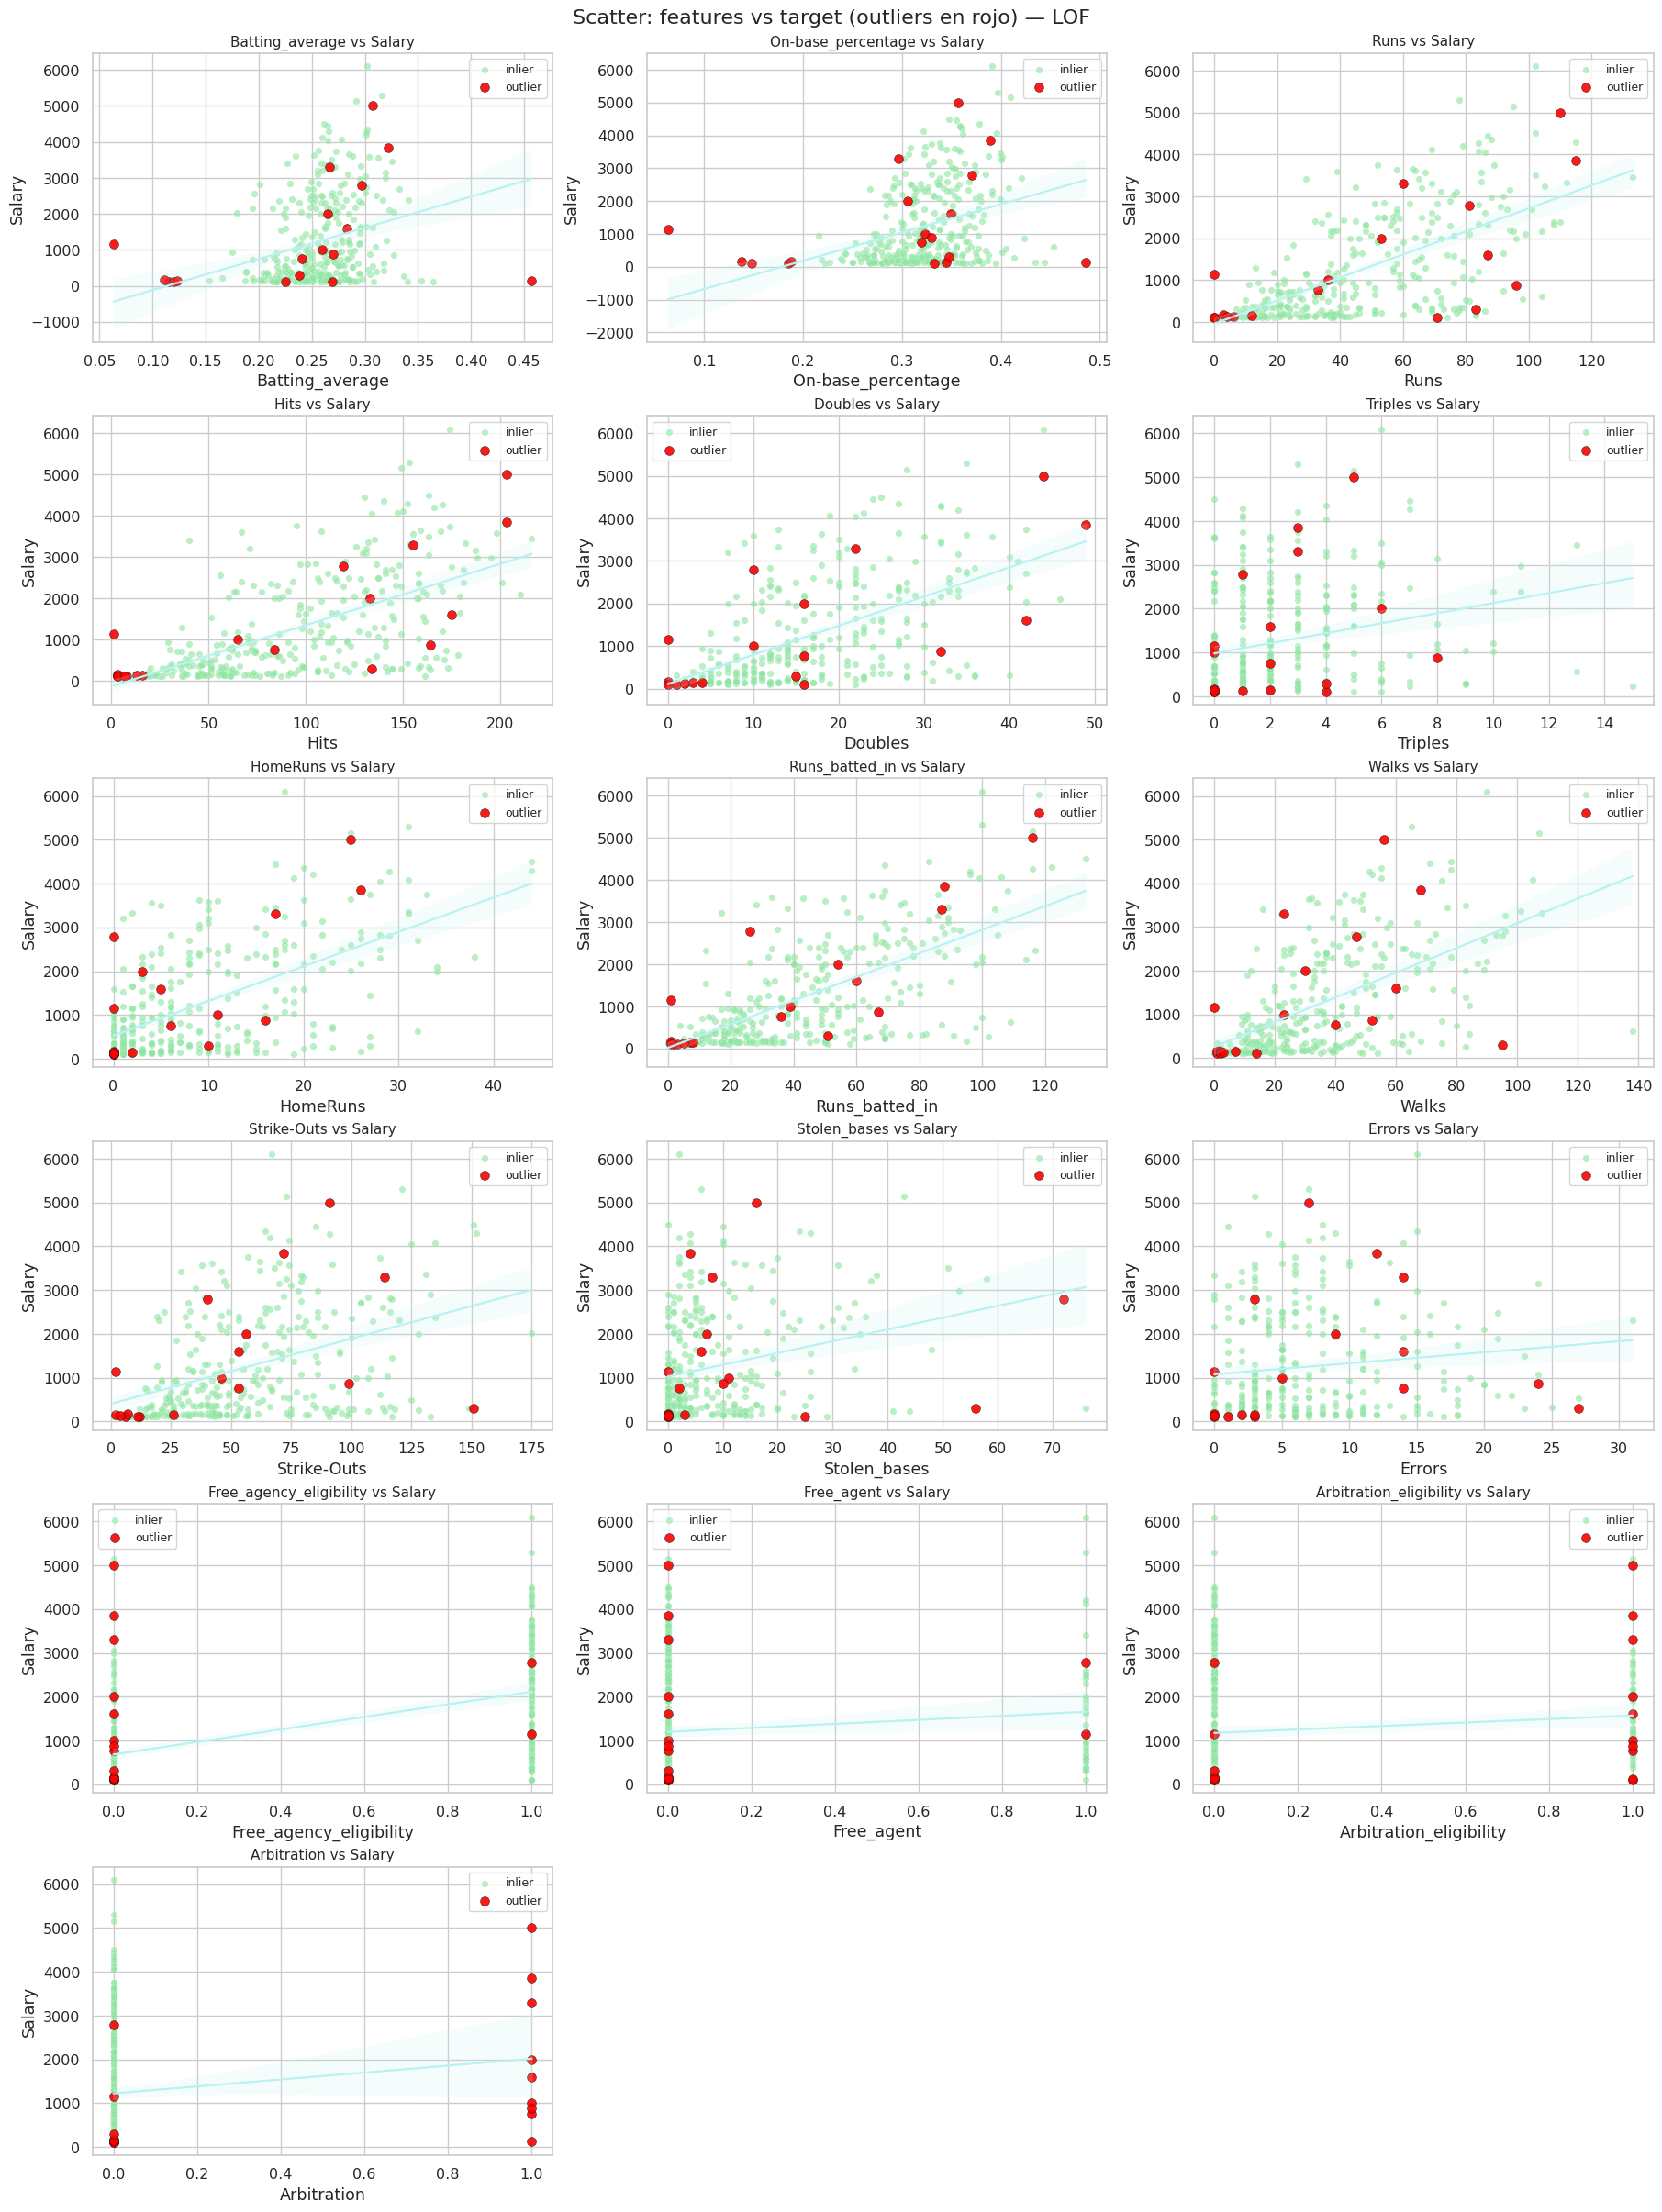

In [11]:
target = "Salary"
features_no_target = [c for c in features if c != target]
n2 = len(features_no_target)
rows2 = math.ceil(n2 / cols_per_row)

fig, axes = plt.subplots(rows2, cols_per_row, figsize=(18, 4*rows2), constrained_layout=True)
axes = axes.flatten()

for i, feat in enumerate(features_no_target):
    ax = axes[i]
    # plot inliers
    sns.scatterplot(x=df.loc[~df["is_outlier"], feat], y=df.loc[~df["is_outlier"], target],
                    ax=ax, color=color_main, s=28, alpha=0.6, edgecolor="w", linewidth=0.2, label="inlier")
    # plot outliers in red
    sns.scatterplot(x=df.loc[df["is_outlier"], feat], y=df.loc[df["is_outlier"], target],
                    ax=ax, color="red", s=50, alpha=0.9, edgecolor="k", linewidth=0.4, label="outlier")
    # tendencia sobre todos los datos
    sns.regplot(x=df[feat], y=df[target], scatter=False, ax=ax, line_kws={"color": color_accent, "linewidth":1.6})
    ax.set_title(f"{feat} vs {target}", fontsize=11)
    ax.set_xlabel(feat)
    ax.set_ylabel(target)
    ax.legend(loc="best", fontsize=9)

for j in range(n2, rows2*cols_per_row):
    fig.delaxes(axes[j])

fig.suptitle("Scatter: features vs target (outliers en rojo) — LOF", fontsize=16)
plt.show()

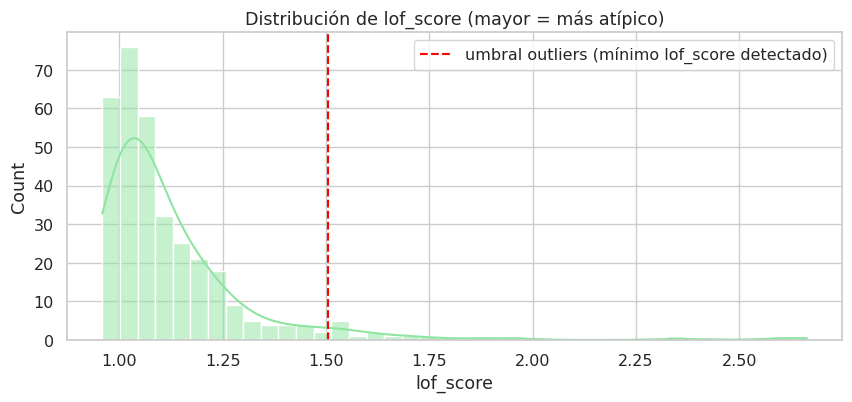

In [12]:
# Mapa de scores LOF (histograma + top outliers)
plt.figure(figsize=(10,4))
sns.histplot(df["lof_score"], bins=40, kde=True, color=color_main)
plt.title("Distribución de lof_score (mayor = más atípico)")
plt.xlabel("lof_score")
plt.axvline(df.loc[df['is_outlier'], 'lof_score'].min(), color="red", linestyle="--",
            label="umbral outliers (mínimo lof_score detectado)")
plt.legend()
plt.show()

In [13]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler


X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 1. Define la rejilla completa de hiperparámetros
neighbors_grid = [3, 9, 15, 27, 49]
metric_grid = ['euclidean', 'manhattan', 'minkowski']

results = []

print("Iniciando búsqueda manual en rejilla...")

for n_neighbors, metric in product(neighbors_grid, metric_grid):

    # Crea la instancia de LOF con la combinación actual
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        metric=metric,
        novelty=False
    )

    # Ajusta y predice
    y_pred = lof.fit_predict(X_scaled)

    # Calcula las métricas
    lof_score = -lof.negative_outlier_factor_
    n_outliers = (y_pred == -1).sum()

    # Calcula el score medio solo si se encontraron outliers
    mean_lof = lof_score[y_pred == -1].mean() if n_outliers > 0 else 0.0

    # Guarda los resultados
    results.append({
        "n_neighbors": n_neighbors,
        "metric": metric,
        "n_outliers": n_outliers,
        "mean_lof_score": mean_lof
    })

print("¡Búsqueda finalizada!")

df_grid = pd.DataFrame(results)


df_grid_sorted = df_grid.sort_values(by="mean_lof_score", ascending=False).reset_index(drop=True)

print("\n--- Top 15 Mejores Combinaciones (según Mean LOF Score) ---")
display(df_grid_sorted.head(15))

Iniciando búsqueda manual en rejilla...
¡Búsqueda finalizada!

--- Top 15 Mejores Combinaciones (según Mean LOF Score) ---


,n_neighbors,metric,n_outliers,mean_lof_score
0,3,manhattan,13,1.971907
1,9,manhattan,8,1.951412
2,15,manhattan,9,1.888009
3,27,manhattan,8,1.878786
4,3,euclidean,11,1.870124
5,3,minkowski,11,1.870124
6,15,euclidean,12,1.865760
7,15,minkowski,12,1.865760
8,49,euclidean,16,1.794385
9,49,minkowski,16,1.794385


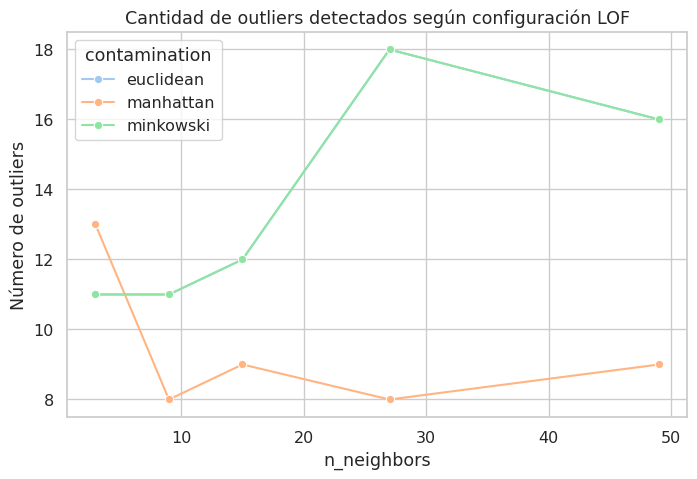

In [14]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df_grid, x="n_neighbors", y="n_outliers",
      hue="metric", marker="o", palette="pastel")
plt.title("Cantidad de outliers detectados según configuración LOF")
plt.ylabel("Número de outliers")
plt.xlabel("n_neighbors")
plt.legend(title="contamination")
plt.show()


In [15]:
# Crear un DataFrame limpio sin outliers
df_clean = df[~df["is_outlier"]].copy()

print(f"Dataset original: {df.shape[0]} filas")
print(f"Outliers eliminados: {df['is_outlier'].sum()}")
print(f"Dataset limpio: {df_clean.shape[0]} filas")

# Vista rápida de los primeros registros
display(df_clean.head())


Dataset original: 337 filas
Outliers eliminados: 18
Dataset limpio: 319 filas


,Batting_average,On-base_percentage,Runs,Hits,Doubles,Triples,HomeRuns,Runs_batted_in,Walks,Strike-Outs,Stolen_bases,Errors,Free_agency_eligibility,Free_agent,Arbitration_eligibility,Arbitration,Salary,lof_score,is_outlier
0,0.271,0.328,74.0,161.0,22.0,6.0,12.0,58.0,49.0,133.0,23.0,17.0,1.0,1.0,0.0,0.0,109.0,1.219400,False
1,0.264,0.318,24.0,48.0,7.0,0.0,1.0,22.0,15.0,18.0,0.0,7.0,0.0,0.0,0.0,0.0,160.0,0.985476,False
2,0.251,0.338,101.0,141.0,35.0,3.0,32.0,105.0,71.0,104.0,34.0,6.0,0.0,0.0,1.0,0.0,2700.0,1.174894,False
3,0.224,0.274,28.0,94.0,21.0,1.0,1.0,44.0,27.0,54.0,2.0,7.0,1.0,1.0,0.0,0.0,550.0,0.994884,False
4,0.206,0.262,14.0,51.0,18.0,1.0,1.0,28.0,17.0,26.0,0.0,3.0,1.0,1.0,0.0,0.0,300.0,1.066415,False


In [19]:
df_clean.to_csv("baseball_cleanLOF.csv", index=False)
display(df_clean.head())

,Batting_average,On-base_percentage,Runs,Hits,Doubles,Triples,HomeRuns,Runs_batted_in,Walks,Strike-Outs,Stolen_bases,Errors,Free_agency_eligibility,Free_agent,Arbitration_eligibility,Arbitration,Salary,lof_score,is_outlier
0,0.271,0.328,74.0,161.0,22.0,6.0,12.0,58.0,49.0,133.0,23.0,17.0,1.0,1.0,0.0,0.0,109.0,1.219400,False
1,0.264,0.318,24.0,48.0,7.0,0.0,1.0,22.0,15.0,18.0,0.0,7.0,0.0,0.0,0.0,0.0,160.0,0.985476,False
2,0.251,0.338,101.0,141.0,35.0,3.0,32.0,105.0,71.0,104.0,34.0,6.0,0.0,0.0,1.0,0.0,2700.0,1.174894,False
3,0.224,0.274,28.0,94.0,21.0,1.0,1.0,44.0,27.0,54.0,2.0,7.0,1.0,1.0,0.0,0.0,550.0,0.994884,False
4,0.206,0.262,14.0,51.0,18.0,1.0,1.0,28.0,17.0,26.0,0.0,3.0,1.0,1.0,0.0,0.0,300.0,1.066415,False


In [20]:
X_linear = df_clean[['Runs_batted_in']]
y_linear = df_clean['Salary']

print("First few rows of X_linear:")
display(X_linear.head())

print("\nFirst few rows of y_linear:")
display(y_linear.head())

First few rows of X_linear:


,Runs_batted_in
0,58.0
1,22.0
2,105.0
3,44.0
4,28.0



First few rows of y_linear:


,Salary
0,109.0
1,160.0
2,2700.0
3,550.0
4,300.0


In [21]:
!pip install dmba # Data Mining for Business Analytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.8 MB/s eta 0:00:00


In [22]:
# ===== Diagnóstico completo: OLS + t-values + VIF =====
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# (1) Cargar dataset limpio
df = pd.read_csv("baseball_cleanLOF.csv")

X = df.drop(columns=["Salary", "lof_score", "is_outlier"])
y = df["Salary"]


# Separar tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# (2) Normalizar numéricas
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X[num_cols]),
    columns=num_cols,
    index=X.index
)

# (3) One-hot encoding si hay categóricas
if cat_cols:
    X_cat = pd.get_dummies(X[cat_cols], drop_first=True)
    X_proc = pd.concat([X_num_scaled, X_cat], axis=1)
else:
    X_proc = X_num_scaled

# (4) Ajustar modelo OLS
X_proc_const = sm.add_constant(X_proc, has_constant="add")
ols = sm.OLS(y, X_proc_const)
res = ols.fit()

print("\n=== Resumen OLS ===")
print(res.summary())

print("\n=== t-values por coeficiente ===")
print(res.tvalues)

X_vif = sm.add_constant(X_proc)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print("\n=== VIF por variable ===")
print(vif_data)



=== Resumen OLS ===
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     44.37
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.85e-69
Time:                        22:17:59   Log-Likelihood:                -2528.0
No. Observations:                 319   AIC:                             5090.
Df Residuals:                     302   BIC:                             5154.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const


=== Evaluación inicial con Validación Cruzada (MAE) ===
Linear: MAE promedio = 534.7382 (+/- 26.7285)
Ridge: MAE promedio = 533.0344 (+/- 26.4463)
Lasso: MAE promedio = 534.3192 (+/- 26.5111)
ElasticNet: MAE promedio = 573.9450 (+/- 44.5456)

=== Ajuste de Hiperparámetros ===
Ridge -> Mejor MAE: 529.7707 | Params: {'regressor__alpha': 10}
Lasso -> Mejor MAE: 529.6982 | Params: {'regressor__alpha': 10}
ElasticNet -> Mejor MAE: 529.9069 | Params: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}


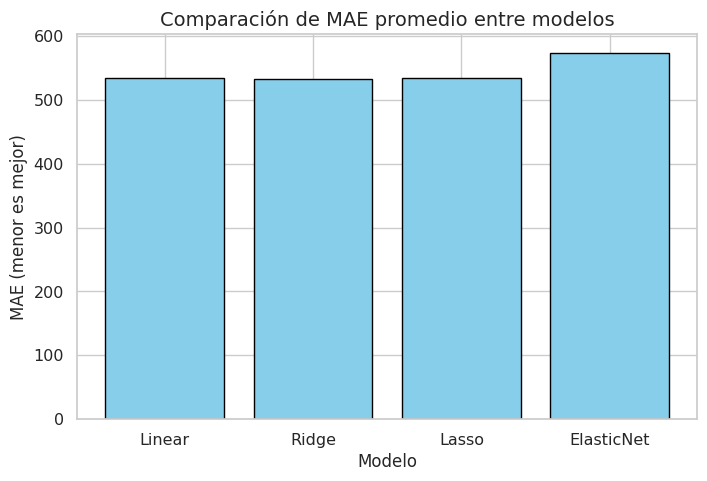

In [23]:

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import matplotlib.pyplot as plt

num_pipe = Pipeline([
    ("scaler", StandardScaler())
])
cat_pipe = OneHotEncoder(drop="first", handle_unknown="ignore") if cat_cols else "drop"

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)


models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42, max_iter=10000),
    "ElasticNet": ElasticNet(random_state=42, max_iter=10000)
}


print("\n=== Evaluación inicial con Validación Cruzada (MAE) ===")
mae_scores = {}
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    scores = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    mae = -scores.mean()
    mae_scores[name] = mae
    print(f"{name}: MAE promedio = {mae:.4f} (+/- {scores.std():.4f})")


param_grids = {
    "Ridge": {"regressor__alpha": [0.01, 0.1, 1, 10, 100]},
    "Lasso": {"regressor__alpha": [0.001, 0.01, 0.1, 1, 10]},
    "ElasticNet": {
        "regressor__alpha": [0.001, 0.01, 0.1, 1, 10],
        "regressor__l1_ratio": [0.2, 0.5, 0.8]
    }
}

print("\n=== Ajuste de Hiperparámetros ===")
best_models = {}
for name, grid in param_grids.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", models[name])
    ])
    search = GridSearchCV(pipe, grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
    search.fit(X, y)
    best_models[name] = search.best_estimator_
    print(f"{name} -> Mejor MAE: {-search.best_score_:.4f} | Params: {search.best_params_}")


df_scores = pd.DataFrame(list(mae_scores.items()), columns=["Modelo", "MAE"])
plt.figure(figsize=(8, 5))
plt.bar(df_scores["Modelo"], df_scores["MAE"], color="skyblue", edgecolor="black")
plt.title("Comparación de MAE promedio entre modelos", fontsize=14)
plt.ylabel("MAE (menor es mejor)", fontsize=12)
plt.xlabel("Modelo", fontsize=12)
plt.show()



=== Baseline (todas las variables): Evaluación inicial (CV MAE) ===
Linear: MAE = 534.7382 (+/- 26.7285)
Ridge: MAE = 533.0344 (+/- 26.4463)
Lasso: MAE = 534.3192 (+/- 26.5111)
ElasticNet: MAE = 573.9450 (+/- 44.5456)

=== Baseline (todas las variables): GridSearch (CV MAE) ===
Ridge -> best MAE: 529.7707 | params: {'regressor__alpha': 10}
Lasso -> best MAE: 529.6982 | params: {'regressor__alpha': 10}
ElasticNet -> best MAE: 529.9069 | params: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}

Variables eliminadas en versión reducida: (ninguna)

=== Reducido (sin agregados grueso/fino): Evaluación inicial (CV MAE) ===
Linear: MAE = 534.7382 (+/- 26.7285)
Ridge: MAE = 533.0344 (+/- 26.4463)
Lasso: MAE = 534.3192 (+/- 26.5111)
ElasticNet: MAE = 573.9450 (+/- 44.5456)

=== Reducido (sin agregados grueso/fino): GridSearch (CV MAE) ===
Ridge -> best MAE: 529.7707 | params: {'regressor__alpha': 10}
Lasso -> best MAE: 529.6982 | params: {'regressor__alpha': 10}
ElasticNet -> best MAE: 52

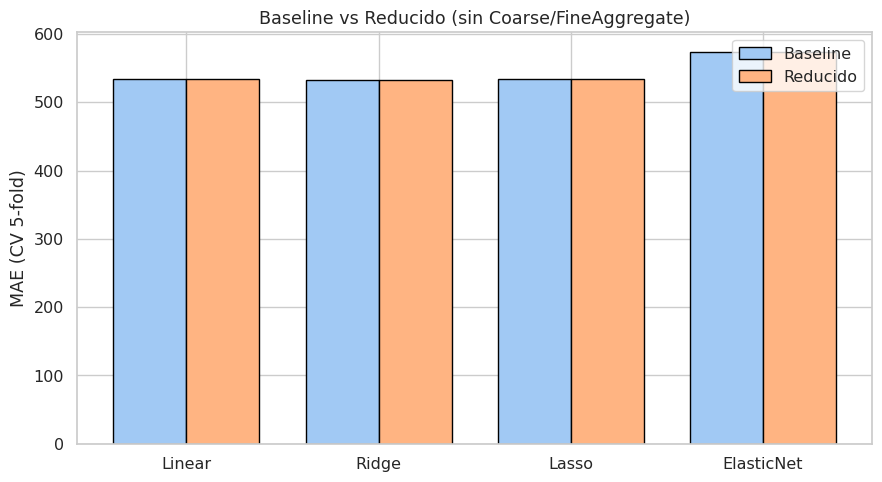


 Mejor baseline: Ridge (MAE=533.0344)
 Mejor reducido: Ridge (MAE=533.0344)
 La versión reducida no mejora (o empata). Mantén el baseline o considera regularización.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

df = pd.read_csv("baseball_cleanLOF.csv")

X_full = df.drop(columns=["Salary", "lof_score", "is_outlier"])
y = df["Salary"]



def build_preprocessor(X):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    num_pipe = Pipeline([("scaler", StandardScaler())])
    cat_pipe = OneHotEncoder(drop="first", handle_unknown="ignore") if cat_cols else "drop"

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
    )
    return preprocessor, num_cols, cat_cols

def eval_models(X, y, title):
    preprocessor, num_cols, cat_cols = build_preprocessor(X)

    models = {
        "Linear": LinearRegression(),
        "Ridge": Ridge(random_state=42),
        "Lasso": Lasso(random_state=42, max_iter=10000),
        "ElasticNet": ElasticNet(random_state=42, max_iter=10000),
    }

    print(f"\n=== {title}: Evaluación inicial (CV MAE) ===")
    mae_scores = {}
    for name, model in models.items():
        pipe = Pipeline([("preprocessor", preprocessor), ("regressor", model)])
        scores = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
        mae_scores[name] = -scores.mean()
        print(f"{name}: MAE = {-scores.mean():.4f} (+/- {scores.std():.4f})")

    param_grids = {
        "Ridge": {"regressor__alpha": [0.01, 0.1, 1, 10, 100]},
        "Lasso": {"regressor__alpha": [0.001, 0.01, 0.1, 1, 10]},
        "ElasticNet": {
            "regressor__alpha": [0.001, 0.01, 0.1, 1, 10],
            "regressor__l1_ratio": [0.2, 0.5, 0.8],
        },
    }

    print(f"\n=== {title}: GridSearch (CV MAE) ===")
    best_models = {}
    for name, grid in param_grids.items():
        pipe = Pipeline([("preprocessor", preprocessor), ("regressor", models[name])])
        search = GridSearchCV(pipe, grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
        search.fit(X, y)
        best_models[name] = search.best_estimator_
        print(f"{name} -> best MAE: {-search.best_score_:.4f} | params: {search.best_params_}")

    return mae_scores, best_models

baseline_mae, baseline_best = eval_models(X_full, y, "Baseline (todas las variables)")

drop_cols = [c for c in ["CoarseAggregate", "FineAggregate"] if c in X_full.columns]
X_reduced = X_full.drop(columns=drop_cols, errors="ignore")

print("\nVariables eliminadas en versión reducida:", drop_cols or "(ninguna)")

reduced_mae, reduced_best = eval_models(X_reduced, y, "Reducido (sin agregados grueso/fino)")

df_plot = pd.DataFrame({
    "Modelo": ["Linear","Ridge","Lasso","ElasticNet"],
    "Baseline_MAE": [baseline_mae.get(m) for m in ["Linear","Ridge","Lasso","ElasticNet"]],
    "Reducido_MAE": [reduced_mae.get(m) for m in ["Linear","Ridge","Lasso","ElasticNet"]],
})
print("\n=== Comparación MAE (menor es mejor) ===")
print(df_plot)

plt.figure(figsize=(9,5))
x = np.arange(len(df_plot))
width = 0.38
plt.bar(x - width/2, df_plot["Baseline_MAE"], width, edgecolor="black", label="Baseline")
plt.bar(x + width/2, df_plot["Reducido_MAE"], width, edgecolor="black", label="Reducido")
plt.xticks(x, df_plot["Modelo"])
plt.ylabel("MAE (CV 5-fold)")
plt.title("Baseline vs Reducido (sin Coarse/FineAggregate)")
plt.legend()
plt.tight_layout()
plt.show()

def best_key(d): return min(d, key=d.get)

best_baseline = best_key(baseline_mae)
best_reduced = best_key(reduced_mae)
print(f"\n Mejor baseline: {best_baseline} (MAE={baseline_mae[best_baseline]:.4f})")
print(f" Mejor reducido: {best_reduced} (MAE={reduced_mae[best_reduced]:.4f})")

if reduced_mae[best_reduced] + 1e-6 < baseline_mae[best_baseline]:
    print("La versión reducida mejora el MAE. Mantén el modelo reducido.")
else:
    print(" La versión reducida no mejora (o empata). Mantén el baseline o considera regularización.")



=== Ranking combinado (MI y F-test) ===
                    feature  MI_score     F_score       p_value
0            Runs_batted_in  0.438382  240.571563  9.142514e-41
1                      Hits  0.420906  185.190567  1.568991e-33
2                      Runs  0.371874  219.173431  4.638567e-38
3                     Walks  0.367977  156.792017  1.681612e-29
4                   Doubles  0.310991  148.284859  3.026632e-28
5   Free_agency_eligibility  0.207682  172.856034  8.257331e-32
6               Strike-Outs  0.136950   60.664246  9.725709e-14
7                  HomeRuns  0.136075  163.479273  1.799006e-30
8   Arbitration_eligibility  0.110988    3.215342  7.390411e-02
9                    Errors  0.089885    4.089305  4.399493e-02
10                  Triples  0.089253   17.482978  3.755355e-05
11       On-base_percentage  0.070912   44.285232  1.248085e-10
12             Stolen_bases  0.059161   23.421625  2.035377e-06
13               Free_agent  0.027921    4.301245  3.889152e-02

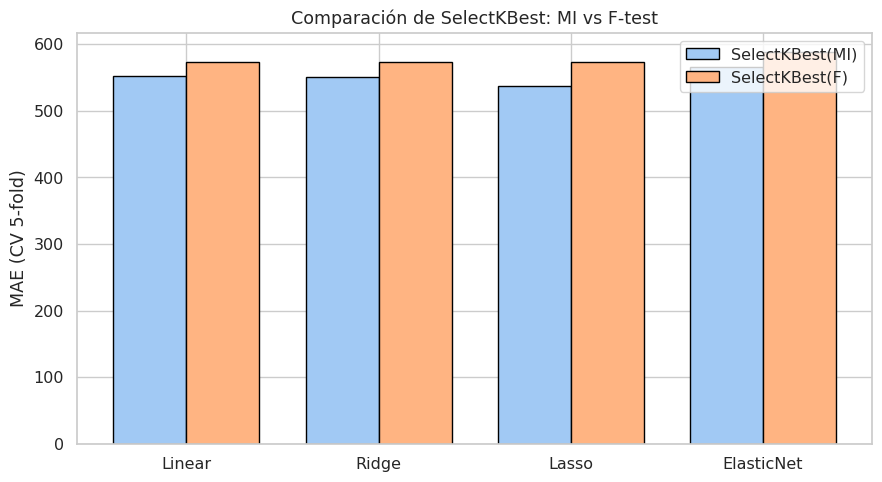


🏁 Mejor con MI: Lasso (MAE=537.6963) | Features: ['Runs', 'Hits', 'Doubles', 'HomeRuns', 'Runs_batted_in', 'Walks', 'Strike-Outs', 'Errors', 'Free_agency_eligibility', 'Arbitration_eligibility']
🏁 Mejor con F : Ridge  (MAE=573.0244)  | Features: ['Runs', 'Hits', 'Doubles', 'HomeRuns', 'Runs_batted_in', 'Walks', 'Strike-Outs', 'Free_agency_eligibility']


In [27]:
# ===== MI vs F-test: análisis de relevancia + pipelines con SelectKBest =====
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# ------------------------------
# 0) Carga datos (concreto limpio)
# ------------------------------
df = pd.read_csv("baseball_cleanLOF.csv")

X = df.drop(columns=["Salary", "lof_score", "is_outlier"])
y = df["Salary"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# -----------------------------------------
# 1) Matriz para scoring (sin constantes)
#    - Escalamos numéricas; dummies si hay
# -----------------------------------------
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols, index=X.index)

if cat_cols:
    X_cat = pd.get_dummies(X[cat_cols], drop_first=True)
    X_scoring = pd.concat([X_num_scaled, X_cat], axis=1)
else:
    X_scoring = X_num_scaled.copy()

# -----------------------------------------
# 2) Scores de relevancia: MI y F-test
# -----------------------------------------
# MI: no lineal; establecemos random_state para reproducibilidad
mi = mutual_info_regression(X_scoring, y, random_state=42)
mi_df = pd.DataFrame({"feature": X_scoring.columns, "MI_score": mi}).sort_values("MI_score", ascending=False)

# F-test: lineal; devuelve F y p-value
F, p = f_regression(X_scoring, y)
f_df = pd.DataFrame({"feature": X_scoring.columns, "F_score": F, "p_value": p}).sort_values("F_score", ascending=False)

# Merge para ver lado a lado
scores = (mi_df.merge(f_df, on="feature")
                .sort_values(["MI_score", "F_score"], ascending=False)
                .reset_index(drop=True))

print("\n=== Ranking combinado (MI y F-test) ===")
print(scores)

print("\nTop por MI:")
print(mi_df.head(10))
print("\nTop por F-score:")
print(f_df.head(10))

# -----------------------------------------
# 3) Pipelines con SelectKBest(MI/F) + modelos
# -----------------------------------------
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

def build_preprocessor(X_):
    num_cols_ = X_.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols_ = X_.select_dtypes(include=["object", "category"]).columns.tolist()
    num_pipe = Pipeline([("scaler", StandardScaler())])
    cat_pipe = OneHotEncoder(drop="first", handle_unknown="ignore") if cat_cols_ else "drop"
    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols_),
            ("cat", cat_pipe, cat_cols_),
        ],
        remainder="drop",
    )
    return pre, num_cols_, cat_cols_

def get_feature_names_after_preprocessor(pre, num_cols_, cat_cols_):
    names = []
    # num: StandardScaler no cambia nombres
    if "num" in pre.named_transformers_ and pre.named_transformers_["num"] != "drop":
        names.extend(num_cols_)
    # cat: OHE genera nuevos nombres
    if cat_cols_ and pre.named_transformers_["cat"] != "drop":
        ohe = pre.named_transformers_["cat"]
        names.extend(ohe.get_feature_names_out(cat_cols_).tolist())
    return names

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42, max_iter=10000),
    "ElasticNet": ElasticNet(random_state=42, max_iter=10000),
}

pre, ncols, ccols = build_preprocessor(X)

# Estimamos dimensión post-prepro para elegir k razonables
_ = pre.fit(X)
try:
    out_dim = pre.transform(X.iloc[:50]).shape[1]
except Exception:
    out_dim = len(ncols)

def k_candidates(out_dim_):
    base = [3, 5, 7, 8, 10, 12]
    return [k for k in base if k <= max(3, out_dim_)]

k_list = k_candidates(out_dim)

def run_selector_grid(score_func, label):
    print(f"\n=== GridSearch con SelectKBest({label}) ===")
    pipe = Pipeline(steps=[
        ("preprocessor", pre),
        ("select", SelectKBest(score_func=score_func, k="all")),
        ("regressor", LinearRegression())
    ])

    param_grid = [
        {"select__k": k_list, "regressor": [LinearRegression()]},
        {"select__k": k_list, "regressor": [Ridge(random_state=42)],
         "regressor__alpha": [0.01, 0.1, 1, 10, 100]},
        {"select__k": k_list, "regressor": [Lasso(random_state=42, max_iter=10000)],
         "regressor__alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"select__k": k_list, "regressor": [ElasticNet(random_state=42, max_iter=10000)],
         "regressor__alpha": [0.001, 0.01, 0.1, 1, 10],
         "regressor__l1_ratio": [0.2, 0.5, 0.8]},
    ]

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=mae_scorer,
        cv=5,
        n_jobs=-1
    )
    gs.fit(X, y)

    print(f"Mejor MAE (CV): {-gs.best_score_:.4f} | Params: {gs.best_params_}")

    # Extra: ¿qué features quedaron?
    best = gs.best_estimator_
    fitted_pre = best.named_steps["preprocessor"]
    feats_all = get_feature_names_after_preprocessor(fitted_pre, ncols, ccols)
    selector = best.named_steps["select"]
    mask = selector.get_support()
    feats_selected = [f for f, keep in zip(feats_all, mask) if keep]
    print(f"Features seleccionadas ({label}, k={selector.k}): {feats_selected}")

    # MAE por modelo usando ese mejor pipeline
    model_mae = {}
    for mname in models.keys():
        # clonar configuración pero cambiando solo el regressor
        cfg = best.get_params()
        cfg["regressor"] = models[mname]
        tuned = Pipeline([
            ("preprocessor", pre),
            ("select", SelectKBest(score_func=score_func, k=selector.k)),
            ("regressor", cfg["regressor"])
        ])
        # Nota: sin re-tunear hiperparámetros aquí; es comparativo puro
        cv_scores = cross_val_score(tuned, X, y, cv=5, scoring=mae_scorer, n_jobs=-1)
        model_mae[mname] = -cv_scores.mean()

    print(f"MAE por modelo con {label} (k={selector.k}): {model_mae}")
    return gs, feats_selected, model_mae

gs_mi, feats_mi, mae_mi = run_selector_grid(mutual_info_regression, "MI")
gs_f,  feats_f,  mae_f  = run_selector_grid(f_regression, "F-test")

# ------------------------------
# 4) Comparación visual rápida
# ------------------------------
df_plot = pd.DataFrame({
    "Modelo": list(models.keys()),
    "MAE_MI": [mae_mi[m] for m in models.keys()],
    "MAE_F":  [mae_f[m]  for m in models.keys()],
})
print("\n=== Comparación MAE por modelo (MI vs F-test) ===")
print(df_plot)

plt.figure(figsize=(9,5))
x = np.arange(len(df_plot))
w = 0.38
plt.bar(x - w/2, df_plot["MAE_MI"], w, edgecolor="black", label="SelectKBest(MI)")
plt.bar(x + w/2, df_plot["MAE_F"],  w, edgecolor="black", label="SelectKBest(F)")
plt.xticks(x, df_plot["Modelo"])
plt.ylabel("MAE (CV 5-fold)")
plt.title("Comparación de SelectKBest: MI vs F-test")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# 5) Ganadores globales
# ------------------------------
best_mi = min(mae_mi, key=mae_mi.get)
best_f  = min(mae_f,  key=mae_f.get)
print(f"\n🏁 Mejor con MI: {best_mi} (MAE={mae_mi[best_mi]:.4f}) | Features: {feats_mi}")
print(f"🏁 Mejor con F : {best_f}  (MAE={mae_f[best_f]:.4f})  | Features: {feats_f}")
